In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Parameters

n = 1000
s = 10

m = 250

In [3]:
# Generate (effectively) sparse vector x_0

def generate_sparse_randn(n, s):
    x = np.zeros(n)
    # select components
    I = np.random.randint(0, n, s)
    x[I] = np.random.randn(s)
    return x

def generate_sparse(n, s):
    x = np.zeros(n)
    # select components
    I = np.random.randint(0, n, s)
    x[I] = 1
    return x

In [4]:
x_0 = generate_sparse_randn(n, s)
# x_0 = generate_sparse(n, s)

In [5]:
# Generate sensing matrix

A = np.random.randn(m, n)

In [6]:
# Compute y
def sign(v):
    return np.where(v < 0, -1.0, 1.0)

y = sign(A.dot(x_0))

In [7]:
def reconstruct_1bit(y, A):
    """
    Solve the modified basis pursuit problem by Plan and Vershynin.

    Solves the linear program

        min ||x||_1
        s.t. sign(Ax) = y
         and ||Ax||_1 = m

    Using dummy variables for ||x||_1, can be removed since cvxpy handles
    them.

    Args:
        y: (m,) ndarray
        A: (m, n) ndarray
    """
    m, n = A.shape
    x = cp.Variable(shape=n)
    u = cp.Variable(shape=n)

    constraints = []
    # - u_i <= x_i <= u_i
    for i in range(n):
        constraints += [
            u[i] >= 0,
            x[i] >= -u[i],
            x[i] <= u[i],
        ]

    # y_i*<a_i, x> >= 0
    for i in range(m):
        constraints += [
            y[i] * cp.sum(cp.multiply(A[i], x)) >= 0,
        ]

    # 1/m sum() >= 1
    constraints.append(cp.sum(cp.multiply(y, A @ x)) / m >= 1)

    objective = cp.Minimize(cp.sum(u))
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return x.value

In [8]:
def reconstruct(y, A):
    """ 
    Solve the Basis pursuit problem with cvxpy.
    
    Solves the linear program
    
        min ||x||_1
        s.t. A @ x = y
    
    Args:
        y: (m,) ndarray
        A: (m, n) ndarray
    """
    m, n = A.shape
    x = cp.Variable(shape=n)
    
    constraints = [A @ x == y, ]

    objective = cp.Minimize(cp.norm1(x))
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return x.value

In [9]:
xx = reconstruct_1bit(y, A)

In [10]:
xx_cs = reconstruct(y, A)

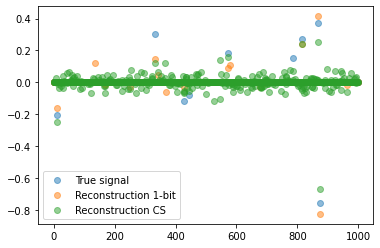

In [11]:
plt.scatter(np.arange(n), x_0 / np.linalg.norm(x_0), alpha=0.5, label="True signal")
plt.scatter(np.arange(n), xx / np.linalg.norm(xx), alpha=0.5, label="Reconstruction 1-bit")
plt.scatter(np.arange(n), xx_cs / np.linalg.norm(xx_cs), alpha=0.5, label="Reconstruction CS")
plt.legend()
plt.show()